In [1]:
# Ignore warnings
import warnings

# warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)

from typing import Optional, Tuple, Any

from samna.dynapse2 import *
import samna

# Utils
import numpy as np
from tqdm import tqdm
import time

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.modules.jax import LIFJax
from rockpool.nn.combinators import Sequential

# DynapSE
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.utils.figure import Figure
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train
from rockpool.nn.modules.module import ModuleBase
# from rockpool.devices.dynapse.ref.weights_old import WeightParameters
from rockpool.devices.dynapse.quantize.weight_handler import WeightHandler

## Dynap-SE2
from rockpool.devices.dynapse.config.simconfig import DynapSimConfig
from rockpool.devices.dynapse.samna_alias import dynapse2 as ds2
from rockpool.devices.dynapse.interface.utils import find_dynapse_boards, configure_dynapse2_fpga, get_model, disconnect, capture_timeseries_from_device, dispatch_timeseries_to_device


# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [ ]:
# Ignore warnings
import warnings

# warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)

from typing import Optional, Tuple, Any

from samna.dynapse2 import *
import samna

# Utils
import numpy as np
from tqdm import tqdm
import time

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.modules.jax import LIFJax
from rockpool.nn.combinators import Sequential

# DynapSE
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.utils.figure import Figure
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train
from rockpool.nn.modules.module import ModuleBase
# from rockpool.devices.dynapse.ref.weights_old import WeightParameters
from rockpool.devices.dynapse.quantize.weight_handler import WeightHandler

## Dynap-SE2
from rockpool.devices.dynapse.config.simconfig import DynapSimConfig
from rockpool.devices.dynapse.samna_alias import dynapse2 as ds2
from rockpool.devices.dynapse.interface.utils import find_dynapse_boards, configure_dynapse2_fpga, get_model, disconnect, capture_timeseries_from_device, dispatch_timeseries_to_device


# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
T = 500
c = 60
spike_train  = np.random.poisson(0.1, (T,c)).astype(bool)

In [3]:
with open("./frozen_noise_classification/win.npy", "rb") as f:
    w_in = np.load(f)

with open("./frozen_noise_classification/wrec.npy", "rb") as f:
    w_rec = np.load(f)

with open("./frozen_noise_classification/mux_in.npy", "rb") as f:
    mux_in = np.load(f)

with open("./frozen_noise_classification/mux_rec.npy", "rb") as f:
    mux_rec = np.load(f)

with open("./frozen_noise_classification/Iw.npy", "rb") as f:
    Iw = np.load(f)

In [4]:
qmux_in = WeightHandler.int2bit_mask(4, mux_in).T
qmux_in.shape

(2, 60, 4)

In [5]:
qmux_rec = WeightHandler.int2bit_mask(4, mux_rec).T
qmux_rec.shape

(2, 2, 4)

In [6]:
## Utils
def set_parameter(parameters, name, coarse, fine):
    parameter = parameters[name]
    parameter.coarse_value = coarse
    parameter.fine_value = fine


## Connect to device
se2_devices = find_dynapse_boards()

INFO:root: Total of 1 DYNAP-SE2 board(s) found with serial numbers : ['']


In [7]:
found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    board = configure_dynapse2_fpga(se2_devices[0])

INFO:root:DYNAP-SE2 Stack is connected, configured and ready for operation!


In [8]:
model = get_model(board)
## Get model config
myConfig = model.get_configuration()
## Configure Parameters Manually
# [] TODO : All at once

print("Configuring parameters")

simconfig = DynapSimConfig(Iw_0=Iw[0], Iw_1=Iw[1], Iw_2=Iw[2], Iw_3=Iw[3])

param_dict = simconfig.export_Dynapse2Parameters()
for key, value in param_dict.items():
    set_parameter(myConfig.chips[0].cores[0].parameters, key, *value)
    print(key, value)

set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_CASC_P", 5, 254)

Configuring parameters
SOIF_DC_P (0, 4)
DENM_NMREV_N (0, 0)
SOAD_GAIN_P (1, 200)
DEAM_EGAIN_P (3, 92)
DEGA_IGAIN_P (3, 94)
DENM_EGAIN_P (3, 94)
DESC_IGAIN_P (3, 92)
SOIF_GAIN_N (0, 71)
SOAD_PWTAU_N (5, 42)
SYPD_EXT_N (4, 32)
SOIF_REFR_N (1, 223)
SOIF_SPKTHR_P (4, 243)
SOAD_TAU_P (1, 67)
DEAM_ETAU_P (1, 208)
DEGA_ITAU_P (1, 212)
DENM_ETAU_P (1, 212)
DESC_ITAU_P (1, 208)
SOIF_LEAK_N (0, 29)
SYAM_W0_P (5, 255)
SYAM_W1_P (5, 255)
SYAM_W2_P (5, 255)
SYAM_W3_P (5, 255)
SOAD_W_N (2, 58)


In [9]:
cam_weights_in = qmux_in
syn_type_in = (w_in > 0).T

cam_weights_rec = qmux_rec
syn_type_rec = (w_rec > 0).T

In [10]:
print("Configuring cams")

cams0 = [Dynapse2Synapse() for _ in range(64)]
cams1 = [Dynapse2Synapse() for _ in range(64)]

# Neuron 0
for i in range(60):

    # set CAM -- synapses
    cams0[i].tag = 1024 + i
    cams0[i].dendrite = Dendrite.ampa if syn_type_in[0,i] else Dendrite.gaba
    cams0[i].weight = cam_weights_in[0,i]

# REC
cams0[60].tag = 2000
cams0[60].dendrite = Dendrite.ampa if syn_type_rec[0,0] else Dendrite.gaba
cams0[60].weight = cam_weights_rec[0,0]

cams0[61].tag = 2001
cams0[61].dendrite = Dendrite.ampa if syn_type_rec[0,1] else Dendrite.gaba
cams0[61].weight = cam_weights_rec[0,1]


# Neuron 1
for i in range(60):

    # set CAM -- synapses
    cams1[i].tag = 1024 + i
    cams1[i].dendrite = Dendrite.ampa if syn_type_in[1,i] else Dendrite.gaba
    cams1[i].weight = cam_weights_in[1,i]

# REC
cams1[60].tag = 2002
cams1[60].dendrite = Dendrite.ampa if syn_type_rec[1,0] else Dendrite.gaba
cams1[60].weight = cam_weights_rec[1,0]

cams1[61].tag = 2003
cams1[61].dendrite = Dendrite.ampa if syn_type_rec[1,1] else Dendrite.gaba
cams1[61].weight = cam_weights_rec[1,1]

myConfig.chips[0].cores[0].neurons[27].synapses = cams0
myConfig.chips[0].cores[0].neurons[28].synapses = cams1

Configuring cams


In [11]:
print("Configuring srams")

destinations0 = [Dynapse2Destination() for _ in range(4)]

destinations0[0].tag = 2021
destinations0[0].core = [True, False, False, False,]
destinations0[0].x_hop = -1

destinations0[1].tag = 2000
destinations0[1].core = [True, False, False, False,]

destinations0[2].tag = 2001
destinations0[2].core = [True, False, False, False,]

myConfig.chips[0].cores[0].neurons[27].destinations = destinations0


destinations1 = [Dynapse2Destination() for _ in range(4)]
destinations1[0].tag = 2022
destinations1[0].core = [True, False, False, False,]
destinations1[0].x_hop = -1

destinations1[1].tag = 2002
destinations1[1].core = [True, False, False, False,]

destinations1[2].tag = 2003
destinations1[2].core = [True, False, False, False,]

myConfig.chips[0].cores[0].neurons[28].destinations = destinations1

model.apply_configuration(myConfig)
time.sleep(1)

Configuring srams


In [12]:
channel_map = {
    i: ds2.Dynapse2Destination(
        core=[True, False, False, False], x_hop=0, y_hop=0, tag=1024 + i
    )
    for i in range(64)
}

In [13]:
pst = TSEvent.from_raster(spike_train,dt=1e-3)
ts_input = dispatch_timeseries_to_device(board, pst, channel_map, offset=1.0)


Rate = [8 6]


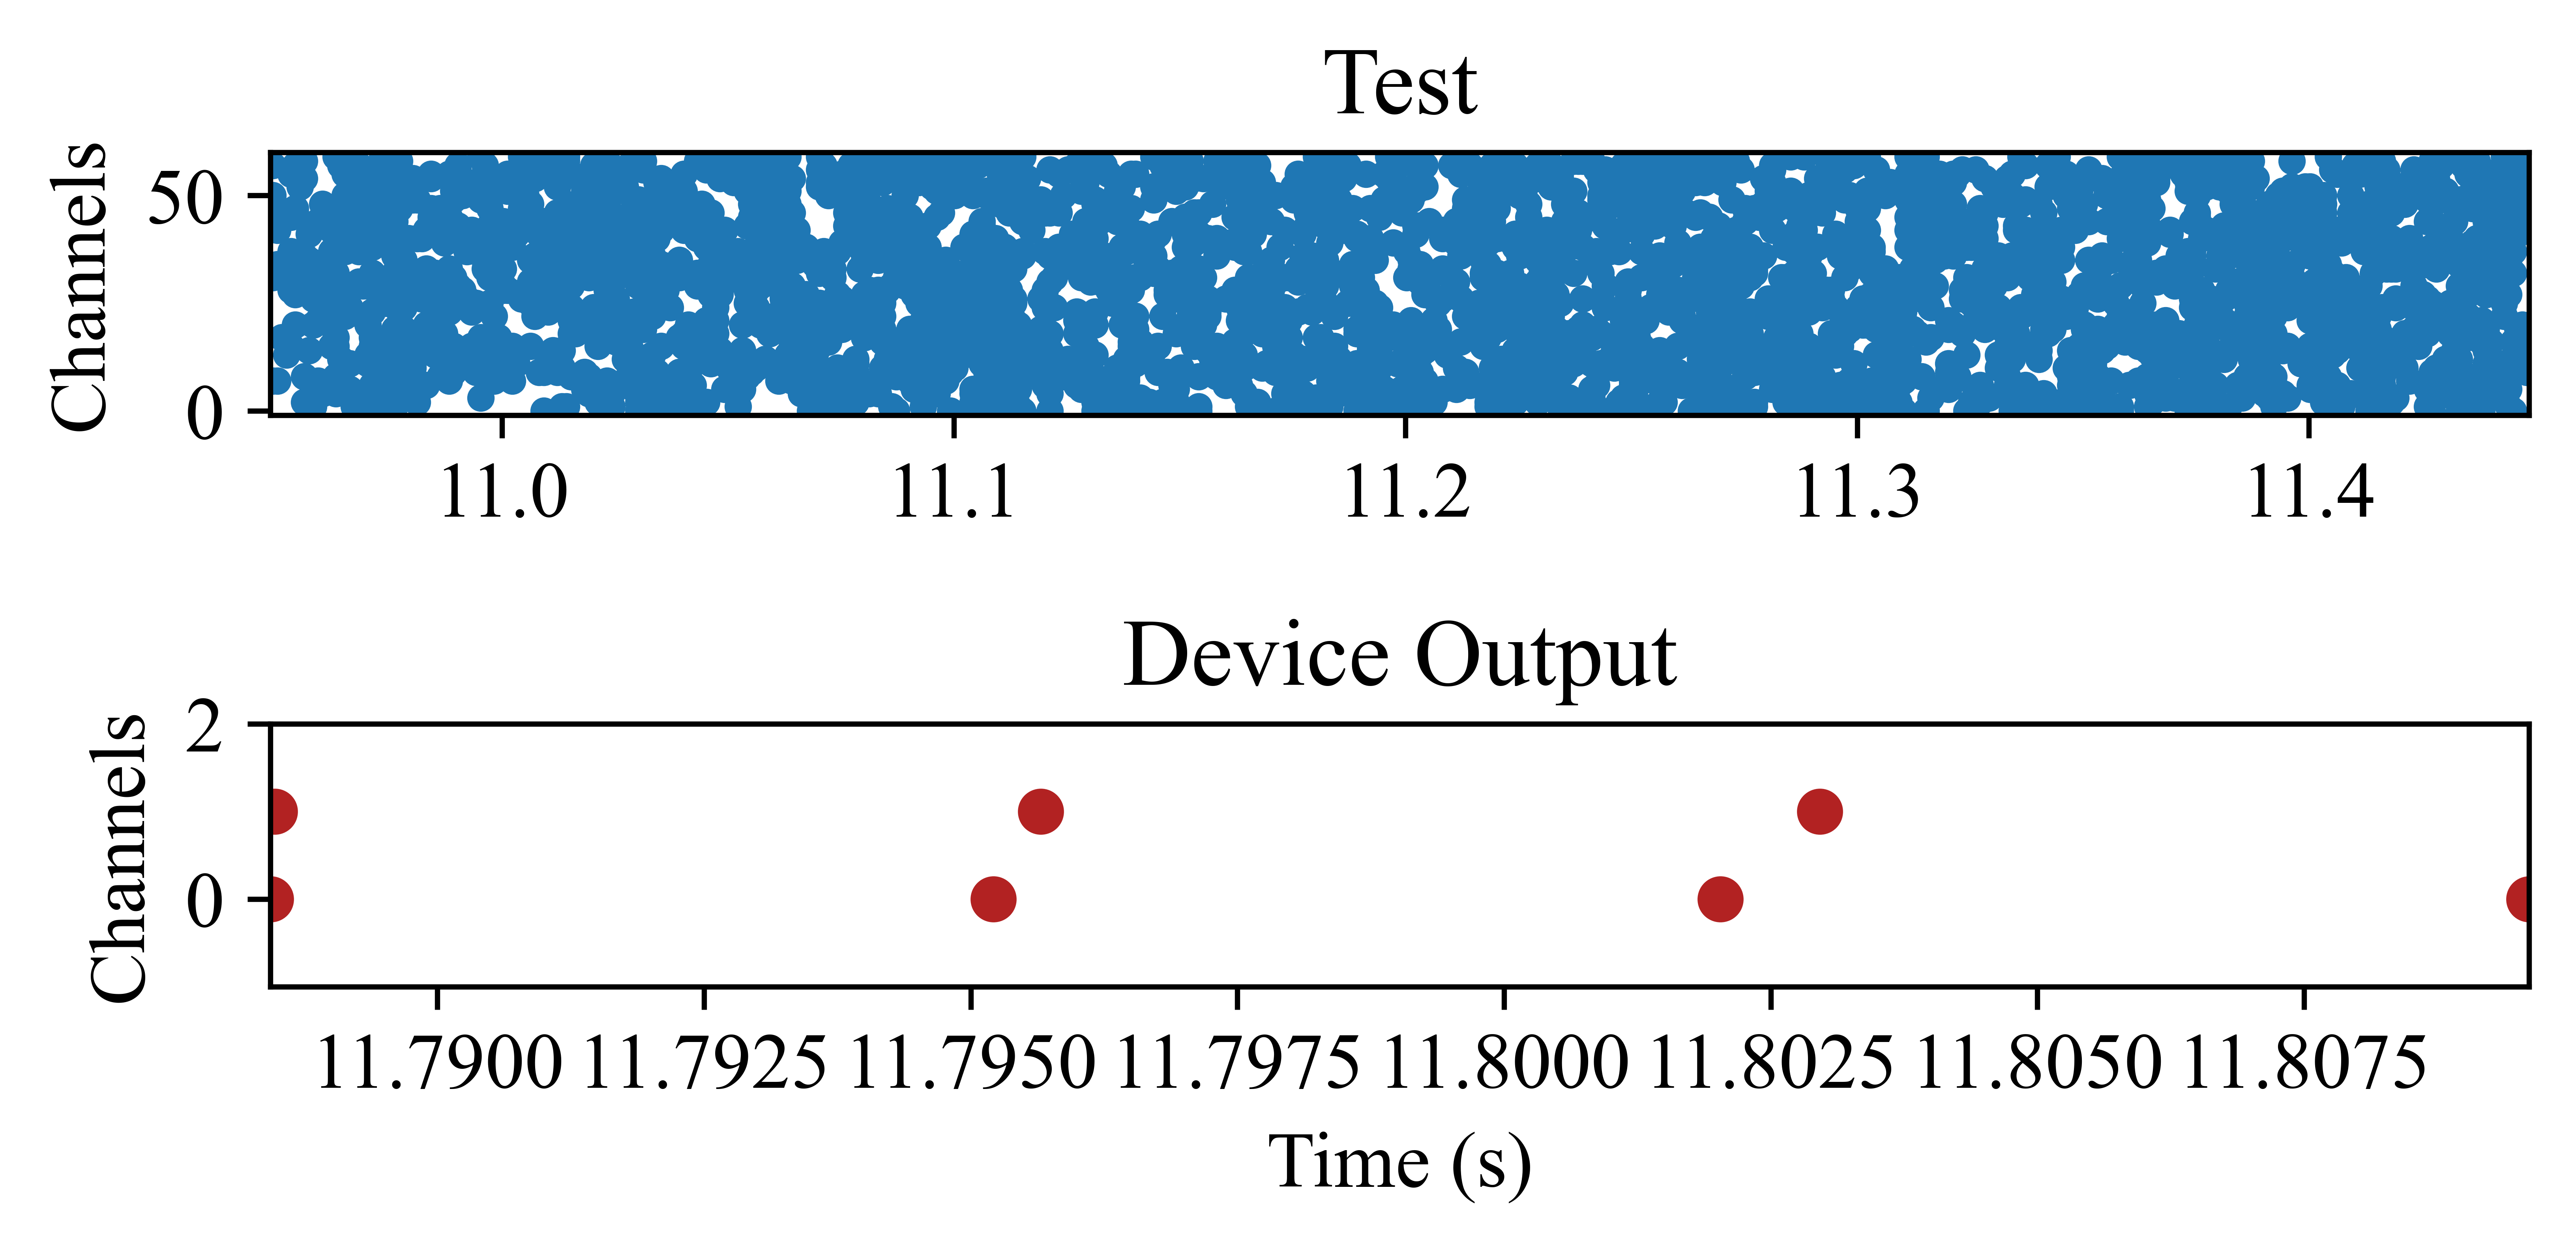

In [14]:
ts_out, cmap_out = capture_timeseries_from_device(board, 5.0)

fig, axes = plt.subplots(2,1)

plt.sca(axes[0])
ts_input.plot(s=10)
plt.title("Test")
plt.xlabel("")

plt.sca(axes[1])
ts_out.plot(color="firebrick")
plt.title("Device Output")
plt.tight_layout()
print(f"Rate = {np.sum(ts_out.raster(dt=1e-3), axis=0)*2}")

In [15]:
disconnect(board)

In [16]:
spike_train

array([[False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

In [17]:
start_time = 10.0
dt = 1e-3
dt_fpga = 1e-6
return_samna = False
duration = len(spike_train) * dt
duration

0.5

In [18]:
from rockpool.devices.dynapse.samna_alias.dynapse2 import (
    Dynapse2Destination,
    NormalGridEvent,
    Dynapse2Interface,
    Dynapse2Model,
    DeviceInfo,
)

In [19]:
channel_map = {
    c: Dynapse2Destination(core=[True] * 4, x_hop=0, y_hop=0, tag=c)
    for c in range(spike_train.shape[1])
}

In [20]:
buffer = []
for spikes, time in zip(spike_train, np.arange(start_time, start_time+duration, dt)):
    # print(time_slice)
    destinations = np.argwhere(spikes).flatten()
    timestamp = int(np.around((time / dt_fpga)))
    events = [NormalGridEvent(channel_map[dest], timestamp) for dest in destinations]
    if return_samna:
        events = [event.samna_object(se2.NormalGridEvent) for event in events]
    buffer.append(events)
    # print(timestamp)

In [2]:
import numpy as np